# **Fiverr Freelance Data Analysis**

#####Step 1: Import Libraries and Load Dataset

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import re

##### STEP 2: Load Dataset

In [192]:
file_path = "/content/drive/MyDrive/fiverr.csv"
df = pd.read_csv(file_path)
print("Dataset Loaded Successfully!")

Dataset Loaded Successfully!


##**Initial Data Exploration**

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       6183 non-null   object
 1   Category-href  6183 non-null   object
 2   Subcat         6183 non-null   object
 3   Subcat-href    6183 non-null   object
 4   name           6183 non-null   object
 5   stars          5690 non-null   object
 6   price          6183 non-null   object
dtypes: object(7)
memory usage: 338.3+ KB


In [159]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

Shape: (6183, 7)

Columns: ['Category', 'Category-href', 'Subcat', 'Subcat-href', 'name', 'stars', 'price']


,Category,Category-href,Subcat,Subcat-href,name,stars,price
0,Programming & Tech,https://www.fiverr.com/categories/programming-...,Data Analysis & Reports,https://www.fiverr.com/categories/programming-...,I will build automated and insightful power bi...,5.0(10),Starting at€137.76
1,Lifestyle,https://www.fiverr.com/categories/lifestyle?so...,Greeting Cards & Videos,https://www.fiverr.com/categories/lifestyle/gr...,I will get kermit to personalize a video birth...,5.0(1k+),Starting at€4.44
2,Programming & Tech,https://www.fiverr.com/categories/programming-...,Website Builders & CMS,https://www.fiverr.com/categories/programming-...,I will build or redesign your existing squares...,5.0(68),Starting at€66.66
3,Lifestyle,https://www.fiverr.com/categories/lifestyle?so...,Cooking Lessons,https://www.fiverr.com/categories/lifestyle/co...,I will create original eastern food cooking vi...,4.9(5),Starting at€17.78
4,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Legal Writing,https://www.fiverr.com/categories/writing-tran...,I will write gdpr privacy policy and terms and...,5.0(2),Starting at€8.89


In [160]:
df.describe()

,Category,Category-href,Subcat,Subcat-href,name,stars,price
count,6183,6183,6183,6183,6183,5690,6183
unique,7,7,129,129,6062,933,142
top,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Data Analysis & Reports,https://www.fiverr.com/categories/programming-...,I will be your personal stylist,5.0(1),Starting at€4.44
freq,1440,1440,48,48,5,490,986


In [161]:
df.isnull().sum()

,0
Category,0
Category-href,0
Subcat,0
Subcat-href,0
name,0
stars,493
price,0


# **Data Cleaning**

##### Step 3: Clean Column Names

In [199]:
# Remove leading/trailing spaces from string cells
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip()

In [200]:
# Clean 'stars' column (extract rating + review count)
if 'stars' not in df.columns:
    df['stars'] = np.nan  # create empty column if not present (for safety)

# Step 1: Fill NaNs with empty string for safe regex operations
df['stars'] = df['stars'].fillna('').astype(str).str.strip()

# Step 2: Extract numeric star rating (first number before '(')
df['star_rating'] = df['stars'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

# Step 3: Extract review count from parentheses: e.g. (1k+), (10), (350)
df['review_raw'] = df['stars'].str.extract(r'\(([^)]+)\)')[0]  # content inside parentheses

# Step 4: Convert review_raw like "1k+", "2.5k", "10" → numeric count
def parse_review_count(val):
    if pd.isna(val) or val == '':
        return np.nan
    val = val.lower().replace('+','').strip()
    # handle "k" or "k+"
    if 'k' in val:
        try:
            return float(val.replace('k','')) * 1000
        except:
            return np.nan
    # pure digits
    try:
        return float(re.sub(r'[^0-9.]','', val))
    except:
        return np.nan

df['review_count'] = df['review_raw'].apply(parse_review_count)

# Quick check of parsing results
print(df[['stars','star_rating','review_raw','review_count']].head(10))

      stars  star_rating review_raw  review_count
0   5.0(10)          5.0         10          10.0
1  5.0(1k+)          5.0        1k+        1000.0
2   5.0(68)          5.0         68          68.0
3    4.9(5)          4.9          5           5.0
4    5.0(2)          5.0          2           2.0
5       nan          NaN        NaN           NaN
6       nan          NaN        NaN           NaN
7   5.0(57)          5.0         57          57.0
8  5.0(309)          5.0        309         309.0
9    5.0(4)          5.0          4           4.0


##### Step 4:Remove Duplicates

In [201]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
df = df.drop_duplicates()
print("Duplicates removed.")

Duplicate rows found: 0
Duplicates removed.


#####Step 5: Handle Missing Values

In [202]:
#Check Missing Values
print("\nMissing values before cleaning:\n", df.isnull().sum())
# Drop columns with >35% missing
threshold = 0.35
df = df.loc[:, df.isnull().mean() < threshold]
# Fill missing categorical with mode
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
# Fill missing numeric with median
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values before cleaning:
 category           0
category-href      0
subcat             0
subcat-href        0
name               0
stars              0
price              0
star_rating      493
review_raw       493
review_count     493
dtype: int64

Missing values after cleaning:
 category         0
category-href    0
subcat           0
subcat-href      0
name             0
stars            0
price            0
star_rating      0
review_raw       0
review_count     0
dtype: int64


/tmp/ipython-input-1948795028.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-1948795028.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

##### Step 6: Clean and Convert Price Column

In [204]:
#Convert price column to numeric
def extract_price(x):
    if pd.isna(x):
        return np.nan
    x = str(x)
    # Remove currency symbols and letters
    x = re.sub(r'[^0-9\.\-\s]', '', x)
    # Handle ranges like "10-20" or "10 20"
    if '-' in x:
        parts = [float(p) for p in x.split('-') if p.strip()]
        return np.mean(parts) if parts else np.nan
    elif ' ' in x:
        parts = [float(p) for p in x.split(' ') if p.strip()]
        return np.mean(parts) if parts else np.nan
    try:
        return float(x)
    except:
        return np.nan
df['price_num'] = df['price'].apply(extract_price)
# Remove unrealistic prices
df = df[df['price_num'].between(5, 5000)]
print("\nPrice column cleaned and converted to numeric.")
df[['price', 'price_num']].head()



Price column cleaned and converted to numeric.


,price,price_num
0,Starting at€137.76,137.76
2,Starting at€66.66,66.66
3,Starting at€17.78,17.78
4,Starting at€8.89,8.89
6,Starting at€8.89,8.89


#####Step 7: Convert Stars and Reviews to Numeric

In [167]:
for col in ['stars', 'reviews', 'ratings']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.extract('(\d+\.?\d*)')[0], errors='coerce')
df.head()


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3117439093.py:3: SyntaxWarning: invalid escape sequence '\d'
  df[col] = pd.to_numeric(df[col].astype(str).str.extract('(\d+\.?\d*)')[0], errors='coerce')


,category,category-href,subcat,subcat-href,name,stars,price,star_rating,review_raw,review_count,price_num
0,Programming & Tech,https://www.fiverr.com/categories/programming-...,Data Analysis & Reports,https://www.fiverr.com/categories/programming-...,I will build automated and insightful power bi...,5.0,Starting at€137.76,5.0,10,10.0,137.76
2,Programming & Tech,https://www.fiverr.com/categories/programming-...,Website Builders & CMS,https://www.fiverr.com/categories/programming-...,I will build or redesign your existing squares...,5.0,Starting at€66.66,5.0,68,68.0,66.66
3,Lifestyle,https://www.fiverr.com/categories/lifestyle?so...,Cooking Lessons,https://www.fiverr.com/categories/lifestyle/co...,I will create original eastern food cooking vi...,4.9,Starting at€17.78,4.9,5,5.0,17.78
4,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Legal Writing,https://www.fiverr.com/categories/writing-tran...,I will write gdpr privacy policy and terms and...,5.0,Starting at€8.89,5.0,2,2.0,8.89
6,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Podcast Writing,https://www.fiverr.com/categories/writing-tran...,I will write podcast content and stories,NaN,Starting at€8.89,5.0,1,15.0,8.89


In [168]:
df.head()

,category,category-href,subcat,subcat-href,name,stars,price,star_rating,review_raw,review_count,price_num
0,Programming & Tech,https://www.fiverr.com/categories/programming-...,Data Analysis & Reports,https://www.fiverr.com/categories/programming-...,I will build automated and insightful power bi...,5.0,Starting at€137.76,5.0,10,10.0,137.76
2,Programming & Tech,https://www.fiverr.com/categories/programming-...,Website Builders & CMS,https://www.fiverr.com/categories/programming-...,I will build or redesign your existing squares...,5.0,Starting at€66.66,5.0,68,68.0,66.66
3,Lifestyle,https://www.fiverr.com/categories/lifestyle?so...,Cooking Lessons,https://www.fiverr.com/categories/lifestyle/co...,I will create original eastern food cooking vi...,4.9,Starting at€17.78,4.9,5,5.0,17.78
4,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Legal Writing,https://www.fiverr.com/categories/writing-tran...,I will write gdpr privacy policy and terms and...,5.0,Starting at€8.89,5.0,2,2.0,8.89
6,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Podcast Writing,https://www.fiverr.com/categories/writing-tran...,I will write podcast content and stories,NaN,Starting at€8.89,5.0,1,15.0,8.89


#####Step 8: Outlier Detection and Treatment

In [205]:
#Outlier Detection and Treatment
numeric_cols = [price_col, reviews_col]  # you can also add stars_col if numeric
for col in numeric_cols:
    if col in df.columns:
        # Remove NaNs
        df = df[df[col].notna()]
        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Count outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"🚨 {len(outliers)} outliers detected in '{col}'")
        # Remove them
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
print("Outliers removed. Proceeding to correlation analysis.")
print(f"Remaining rows: {len(df)}")



🚨 504 outliers detected in 'price_num'
🚨 651 outliers detected in 'review_count'
Outliers removed. Proceeding to correlation analysis.
Remaining rows: 4041


#####Step 9: Inspect Cleaned Dataset

In [170]:
print("Final Shape:", df.shape)
print("Data Types:\n", df.dtypes)
print("\nSample Data:\n", df.head())


Final Shape: (4041, 11)
Data Types:
 category          object
category-href     object
subcat            object
subcat-href       object
name              object
stars            float64
price             object
star_rating      float64
review_raw        object
review_count     float64
price_num        float64
dtype: object

Sample Data:
                 category                                      category-href  \
0     Programming & Tech  https://www.fiverr.com/categories/programming-...   
2     Programming & Tech  https://www.fiverr.com/categories/programming-...   
3              Lifestyle  https://www.fiverr.com/categories/lifestyle?so...   
4  Writing & Translation  https://www.fiverr.com/categories/writing-tran...   
6  Writing & Translation  https://www.fiverr.com/categories/writing-tran...   

                    subcat                                        subcat-href  \
0  Data Analysis & Reports  https://www.fiverr.com/categories/programming-...   
2   Website Builders &

#####Step 10: Save Cleaned Dataset

In [178]:
cleaned_path = "/content/drive/MyDrive/fiverr_cleaned.csv"
df.to_csv(cleaned_path, index=False)
print(f"Cleaned dataset saved to: {cleaned_path}")


Cleaned dataset saved to: /content/drive/MyDrive/fiverr_cleaned.csv


#**Exploratory Data Analysis (EDA)**


In [206]:
CLEANED_CSV = "/content/drive/MyDrive/fiverr_cleaned.csv"   # change if different

# --- LOAD DATA ---
df = pd.read_csv(CLEANED_CSV, low_memory=False)
print("Loaded cleaned dataset:", CLEANED_CSV)
print("Rows,Cols:", df.shape)
display(df.head())

Loaded cleaned dataset: /content/drive/MyDrive/fiverr_cleaned.csv
Rows,Cols: (3462, 11)


,category,category-href,subcat,subcat-href,name,stars,price,star_rating,review_raw,review_count,price_num
0,Programming & Tech,https://www.fiverr.com/categories/programming-...,Website Builders & CMS,https://www.fiverr.com/categories/programming-...,I will build or redesign your existing squares...,5.0,Starting at€66.66,5.0,68,68.0,66.66
1,Lifestyle,https://www.fiverr.com/categories/lifestyle?so...,Cooking Lessons,https://www.fiverr.com/categories/lifestyle/co...,I will create original eastern food cooking vi...,4.9,Starting at€17.78,4.9,5,5.0,17.78
2,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Legal Writing,https://www.fiverr.com/categories/writing-tran...,I will write gdpr privacy policy and terms and...,5.0,Starting at€8.89,5.0,2,2.0,8.89
3,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Podcast Writing,https://www.fiverr.com/categories/writing-tran...,I will write podcast content and stories,NaN,Starting at€8.89,5.0,1,15.0,8.89
4,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Email Copy,https://www.fiverr.com/categories/writing-tran...,I will copywrite your customers favorite emails,5.0,Starting at€31.11,5.0,57,57.0,31.11


 Load Cleaned Dataset for Analysis

In [174]:
df = pd.read_csv(CLEANED_CSV)
print("✅ Dataset loaded successfully!")
print("Rows:", df.shape[0], "Columns:", df.shape[1])
df.head()

✅ Dataset loaded successfully!
Rows: 4041 Columns: 11


,category,category-href,subcat,subcat-href,name,stars,price,star_rating,review_raw,review_count,price_num
0,Programming & Tech,https://www.fiverr.com/categories/programming-...,Data Analysis & Reports,https://www.fiverr.com/categories/programming-...,I will build automated and insightful power bi...,5.0,Starting at€137.76,5.0,10,10.0,137.76
1,Programming & Tech,https://www.fiverr.com/categories/programming-...,Website Builders & CMS,https://www.fiverr.com/categories/programming-...,I will build or redesign your existing squares...,5.0,Starting at€66.66,5.0,68,68.0,66.66
2,Lifestyle,https://www.fiverr.com/categories/lifestyle?so...,Cooking Lessons,https://www.fiverr.com/categories/lifestyle/co...,I will create original eastern food cooking vi...,4.9,Starting at€17.78,4.9,5,5.0,17.78
3,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Legal Writing,https://www.fiverr.com/categories/writing-tran...,I will write gdpr privacy policy and terms and...,5.0,Starting at€8.89,5.0,2,2.0,8.89
4,Writing & Translation,https://www.fiverr.com/categories/writing-tran...,Podcast Writing,https://www.fiverr.com/categories/writing-tran...,I will write podcast content and stories,NaN,Starting at€8.89,5.0,1,15.0,8.89


#####Step 11:Identify Key Columns for Analysis

In [175]:
def find_col(df, names):
    for n in names:
        for c in df.columns:
            if n.lower() in c.lower():
                return c
    return None
price_col = find_col(df, ["price_num", "price"])
cat_col = find_col(df, ["category", "subcat"])
stars_col = find_col(df, ["stars", "rating"])
reviews_col = find_col(df, ["reviews", "review_count"])
print("Using columns → Price:", price_col, "| Category:", cat_col)

Using columns → Price: price_num | Category: category


#####Step 12: Average Price by Category

In [176]:
avg_price = df.groupby(cat_col)[price_col].agg(['count', 'mean', 'median']).reset_index()
avg_price = avg_price.sort_values('mean', ascending=False)
print("\nTop Categories by Average Price:\n")
print(avg_price.head(10))


Top Categories by Average Price:

                category  count       mean  median
5      Video & Animation    767  47.736206   35.55
4     Programming & Tech    507  43.642209   26.66
1      Digital Marketing    233  40.147940   26.66
6  Writing & Translation    991  40.049566   26.66
0               Business    509  38.799548   26.66
3          Music & Audio    519  35.825819   22.22
2              Lifestyle    515  21.003806   13.33


#####Step 13: Bar Chart – Top 15 Categories by Average Price

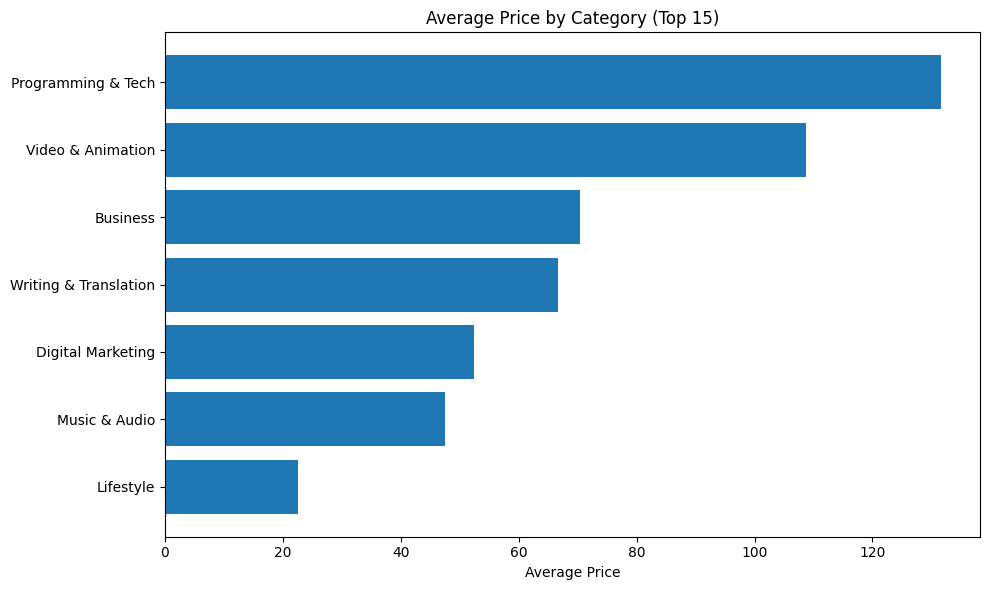

In [146]:
# Bar chart (Top 15)
top15 = avg_price.head(15).sort_values('mean')
plt.figure(figsize=(10,6))
plt.barh(top15[cat_col], top15['mean'])
plt.xlabel("Average Price")
plt.title("Average Price by Category (Top 15)")
plt.tight_layout()
plt.show()

#####Step 14: Skill Distribution (Pie Chart)

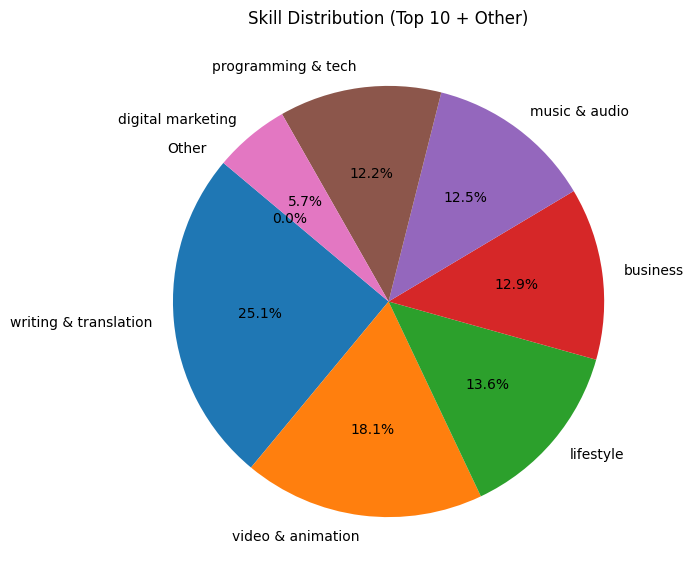

In [187]:
top10 = skill_freq.head(10)
others = skill_freq['count'].sum() - top10['count'].sum()

plt.figure(figsize=(7,7))
plt.pie(
    top10['count'].tolist() + [others],
    labels=top10['skill'].tolist() + ['Other'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Skill Distribution (Top 10 + Other)")
plt.show()


#####Step 15: Correlation: Price vs Stars/Reviews

In [207]:

numeric_cols = [price_col, reviews_col]  # you can also add stars_col if numeric

for col in numeric_cols:
    if col in df.columns:
        # Remove NaNs
        df = df[df[col].notna()]

        # Calculate IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{len(outliers)} outliers detected in '{col}'")

        # Remove them
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(" Outliers removed. Proceeding to correlation analysis.")
print(f"Remaining rows: {len(df)}")


106 outliers detected in 'price_num'
225 outliers detected in 'review_count'
 Outliers removed. Proceeding to correlation analysis.
Remaining rows: 3131


Correlation (Price vs stars): 0.029


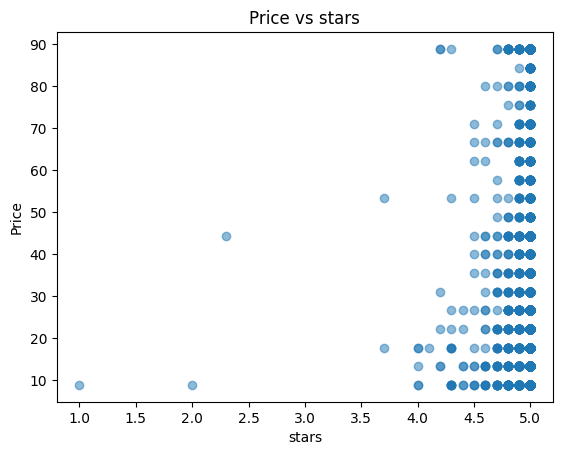

Correlation (Price vs review_count): 0.077


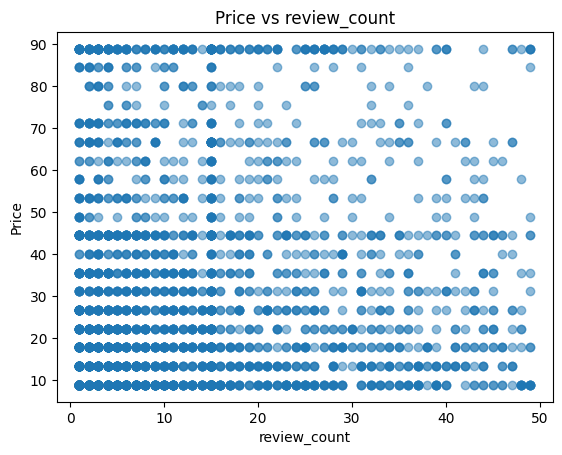

In [208]:
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
if stars_col:
    df[stars_col] = pd.to_numeric(df[stars_col], errors='coerce')
    both = df[[price_col, stars_col]].dropna()
    if not both.empty:
        pearson_r, p_val = stats.pearsonr(both[price_col], both[stars_col])
        print(f"Correlation (Price vs {stars_col}): {pearson_r:.3f}")
        plt.scatter(both[stars_col], both[price_col], alpha=0.5)
        plt.xlabel(stars_col); plt.ylabel("Price")
        plt.title(f"Price vs {stars_col}")
        plt.show()
if reviews_col:
    df[reviews_col] = pd.to_numeric(df[reviews_col], errors='coerce')
    both = df[[price_col, reviews_col]].dropna()
    if not both.empty:
        pearson_r, p_val = stats.pearsonr(both[price_col], both[reviews_col])
        print(f"Correlation (Price vs {reviews_col}): {pearson_r:.3f}")
        plt.scatter(both[reviews_col], both[price_col], alpha=0.5)
        plt.xlabel(reviews_col); plt.ylabel("Price")
        plt.title(f"Price vs {reviews_col}")
        plt.show()


#####Step 16:Price Trend Over Time

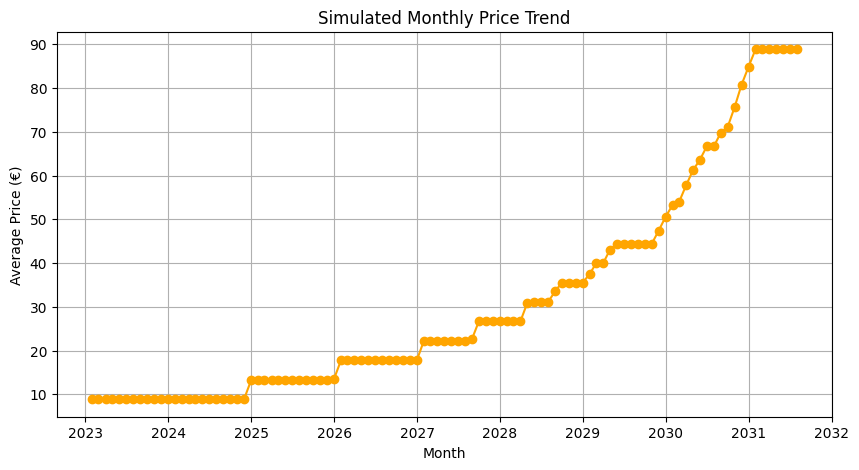

In [209]:
df = df.sort_values(by=price_col).reset_index(drop=True)
df['month'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
trend = df[['month', price_col]].set_index('month').resample('ME').mean()
plt.figure(figsize=(10,5))
plt.plot(trend.index, trend[price_col], marker='o', color='orange')
plt.title("Simulated Monthly Price Trend")
plt.xlabel("Month")
plt.ylabel("Average Price (€)")
plt.grid(True)
plt.show()


#####Step 18:Top Profitable Categories Summary

In [210]:
df['price_num'] = pd.to_numeric(df[price_col], errors='coerce')
profit = df.groupby(cat_col)['price_num'].agg(['mean', 'count']).reset_index()
profit['profit_score'] = profit['mean'] * np.log1p(profit['count'])
top_profitable = profit.sort_values('profit_score', ascending=False).head(10)

print("\nTop 10 Profitable Categories:\n")
print(top_profitable)



Top 10 Profitable Categories:

                category       mean  count  profit_score
5      Video & Animation  37.492294    545    236.299641
6  Writing & Translation  31.451954    788    209.808638
4     Programming & Tech  33.191146    384    197.594968
0               Business  32.443101    416    195.732025
3          Music & Audio  30.733763    380    182.644588
1      Digital Marketing  32.864535    172    169.360531
2              Lifestyle  19.151592    446    116.873712
